In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pywt
import torch 
import scipy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc, random_walk

In [9]:
temp_data = pd.read_csv('../Data/train_data.csv')
# Convert the 'date' column to datetime
temp_data['date'] = pd.to_datetime(temp_data['date'])
temp_data['average_temperature'] = (temp_data['min']+temp_data['max'])/2
temp_data

,date,mean,max,min,average_temperature
0,1933-01-01,13.67,18.89,2.78,10.835
1,1933-01-02,13.89,19.61,1.89,10.750
2,1933-01-03,10.83,16.28,0.78,8.530
3,1933-01-04,14.94,21.28,1.28,11.280
4,1933-01-05,18.11,23.50,6.89,15.195
...,...,...,...,...,...
33281,2024-03-27,12.67,21.28,5.61,13.445
33282,2024-03-28,12.33,20.11,4.22,12.165
33283,2024-03-29,12.11,16.78,5.50,11.140
33284,2024-03-30,9.17,14.61,7.50,11.055


We skip the data analysis that is done in Main.ipynb

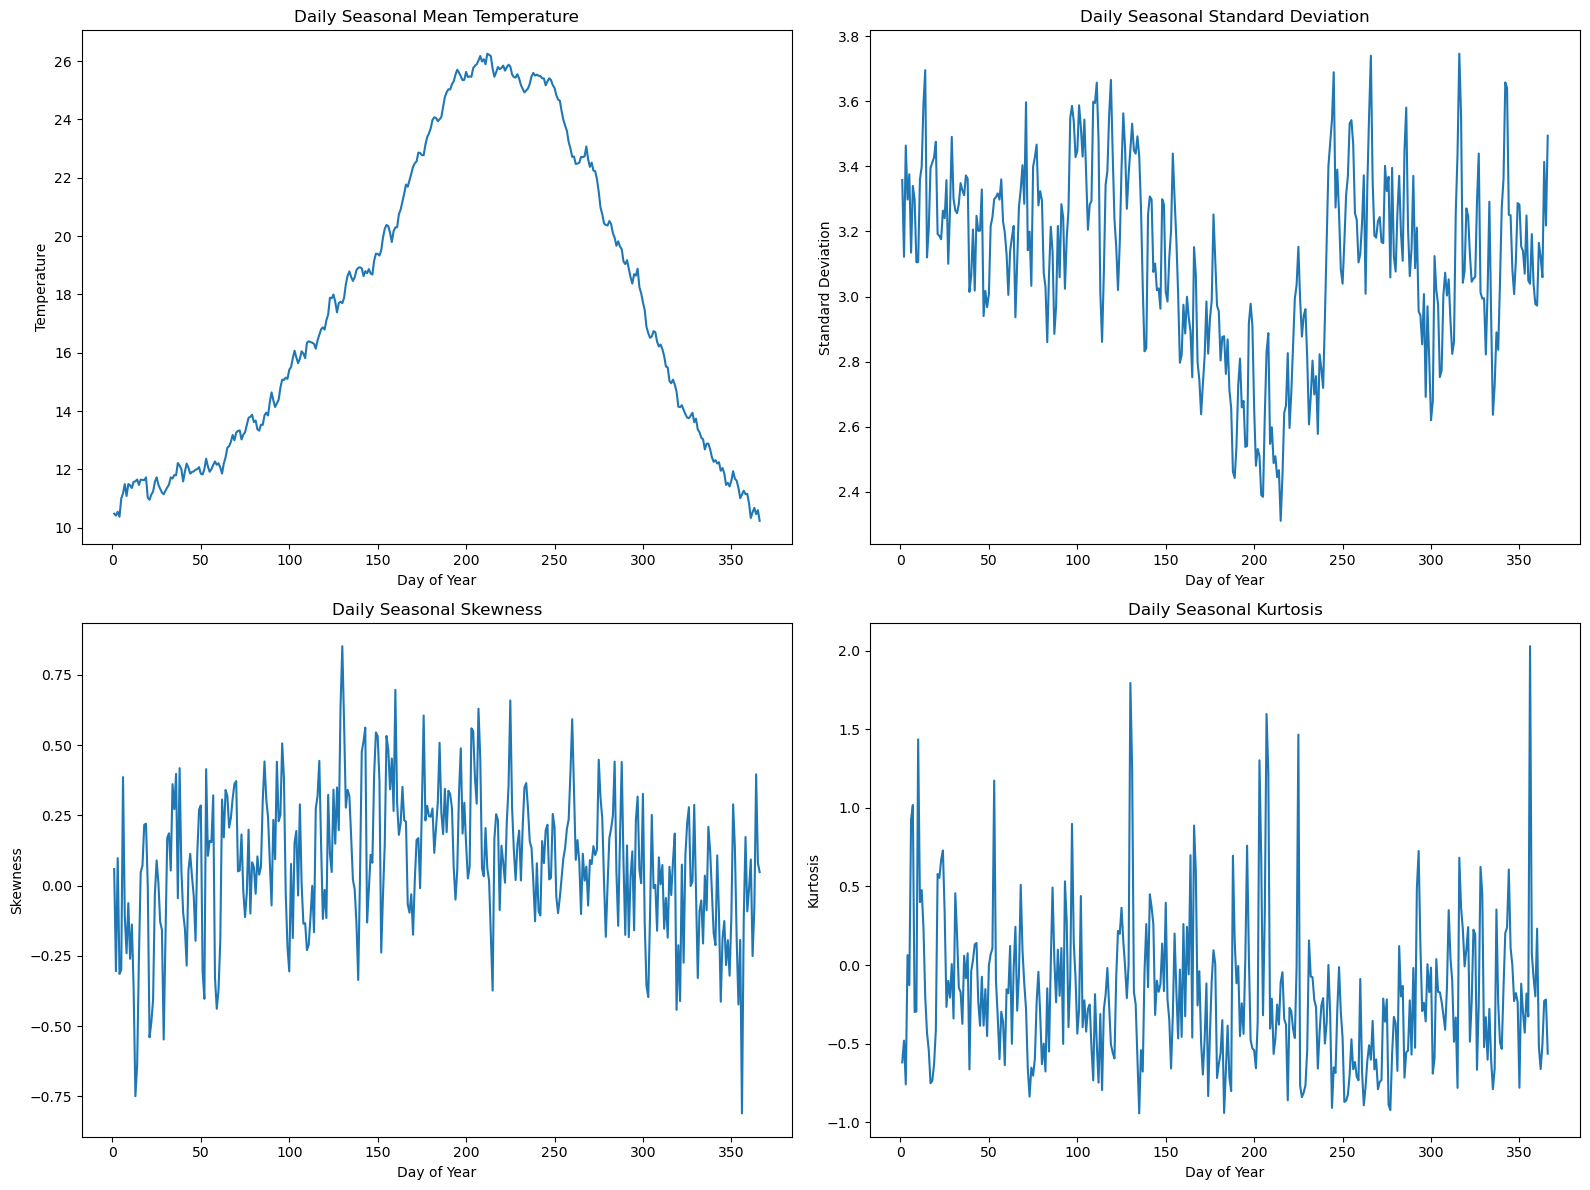

In [10]:
daily_seasonal_mean = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].mean()
daily_seasonal_std = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].std()
daily_seasonal_skew = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].skew()
daily_seasonal_kurtosis = temp_data.groupby(temp_data['date'].dt.dayofyear)['average_temperature'].apply(scipy.stats.kurtosis)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
daily_seasonal_mean.plot(title='Daily Seasonal Mean Temperature')
plt.xlabel('Day of Year')
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
daily_seasonal_std.plot(title='Daily Seasonal Standard Deviation')
plt.xlabel('Day of Year')
plt.ylabel('Standard Deviation')

plt.subplot(2, 2, 3)
daily_seasonal_skew.plot(title='Daily Seasonal Skewness')
plt.xlabel('Day of Year')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
daily_seasonal_kurtosis.plot(title='Daily Seasonal Kurtosis')
plt.xlabel('Day of Year')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

# Detrend and deseasonalize (linear)
- Perform ADF and KPSS tests on the raw temperature data.
- Deseasonalize the temperature data by subtracting the daily seasonal mean.
- Perform ADF and KPSS tests on the deseasonalized temperature data.
- Detrend the time series using an OLS regression.
- Deseasonalize and whiten the detrended series.
- Perform ADF and KPSS tests on the deseasonalized and detrended series.
- Estimate the Hurst exponent of the original and processed series.
- Plot the ACF and PACF of the processed series.
      

In [11]:
# Function to perform the ADF test
def adf_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is non-stationary.")
    print("\n")

# Function to perform the KPSS test
def kpss_test(series, title=''):
    print(f'KPSS Test for {title}')
    result = kpss(series.dropna())
    
    print('KPSS Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is non-stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is stationary.")
    print("\n")

# Perform tests on raw temperature data
adf_test(temp_data['mean'], "Raw Temperature Data")
kpss_test(temp_data['mean'], "Raw Temperature Data")



ADF Test for Raw Temperature Data
ADF Statistic: -14.6789
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Raw Temperature Data
KPSS Statistic: 0.1351
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Failed to reject the null hypothesis (H0). The data is stationary.




/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_15412/3327501187.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


# WA seasonal mean removal

first we need to prep the data further, removing feb 29 and adding an index 

In [12]:
df = temp_data.copy()

# Remove February 29 to have a consistent 365-day calendar
df['day_of_year'] = df['date'].dt.dayofyear
df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))]

# Reset index and add t = 1, 2, ..., N
df = df.reset_index(drop=True)
df['t'] = df.index + 1


we estimate and remove the trend: 
We estimate and remove the trend using a linear regression model defined as:

$$\text{Trend}(t) = a + b \cdot t$$

where:
- $a$ is the intercept parameter
- $b$ is the slope parameter (rate of change over time)
- $t$ is the time index (1, 2, ..., n)

This linear trend is estimated using ordinary least squares (OLS) regression and then subtracted from the original temperature series to obtain the detrended data.


Slope: 0.00002
Intercept: 17.33415
t-statistic: 6.48617
p-value: 0.00000


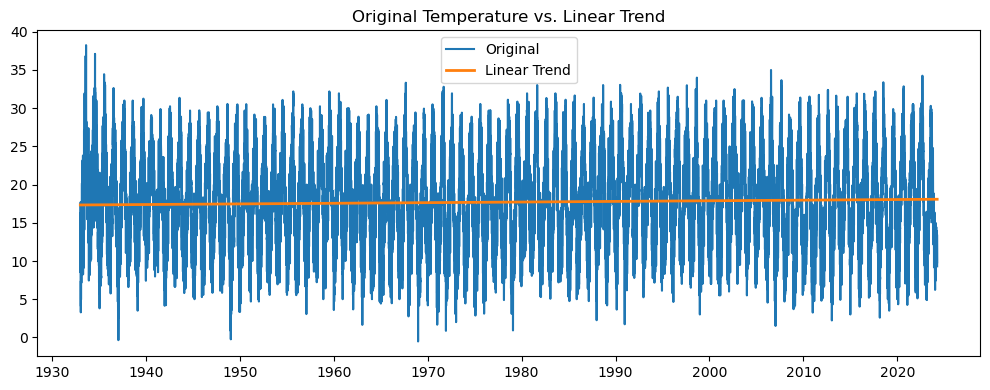

In [13]:
from scipy.stats import linregress

# Extract t and temperature
t = df['t'].values
temp = df['average_temperature'].values

# Fit linear trend and obtain detailed statistics
result = linregress(t, temp)
slope, intercept, r_value, p_value, std_err = result
trend = intercept + slope * t

# Compute t-statistic manually (optional, since p-value is already given by linregress)
t_statistic = slope / std_err

# Print results
print(f"Slope: {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"t-statistic: {t_statistic:.5f}")
print(f"p-value: {p_value:.5f}")

# Add trend and detrended series to DataFrame
df['trend'] = slope * df['t']
df['detrended_temp'] = df['average_temperature'] - df['trend']

# Plot to visualize trend
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['average_temperature'], label='Original')
plt.plot(df['date'], df['trend']+ intercept, label='Linear Trend', linewidth=2)
plt.title('Original Temperature vs. Linear Trend')
plt.legend()
plt.tight_layout()
plt.show()

trend_values = [slope, intercept, r_value, p_value, std_err]

now we decompose the detrended temperature using the Daubechies 11 wavelet

In [14]:

from WA_seasonal_mean import wavelet_decompose

coeff_dict = wavelet_decompose(df['detrended_temp'], wavelet_name='db11')

# Inspect
for key, value in coeff_dict.items():
    print(f"{key}: shape = {value.shape}")


approx: shape = (53,)
detail_1: shape = (16642,)
detail_2: shape = (8331,)
detail_3: shape = (4176,)
detail_4: shape = (2098,)
detail_5: shape = (1059,)
detail_6: shape = (540,)
detail_7: shape = (280,)
detail_8: shape = (150,)
detail_9: shape = (85,)
detail_10: shape = (53,)


In [15]:
import ipywidgets as widgets
from ipywidgets import interact
from WA_seasonal_mean import wavelet_reconstruct

def plot_single_detail(level, coeff_dict):
    single_detail_signal = wavelet_reconstruct(
        coeff_dict,
        keep_levels=[f'detail_{level}'],  # only this detail
        wavelet_name='db11'
    )
    
    plt.figure(figsize=(10, 4))
    plt.plot(single_detail_signal, label=f'Detail {level}')
    plt.title(f"Reconstructed Wavelet Detail {level}")
    plt.legend()
    plt.show()


interact(
    plot_single_detail,
    level=widgets.IntSlider(min=1, max=10, step=1, value=1, description='Detail Level',),
    coeff_dict=widgets.fixed(coeff_dict),
);


interactive(children=(IntSlider(value=1, description='Detail Level', max=10, min=1), Output()), _dom_classes=(…

<Figure size 1500x1000 with 0 Axes>

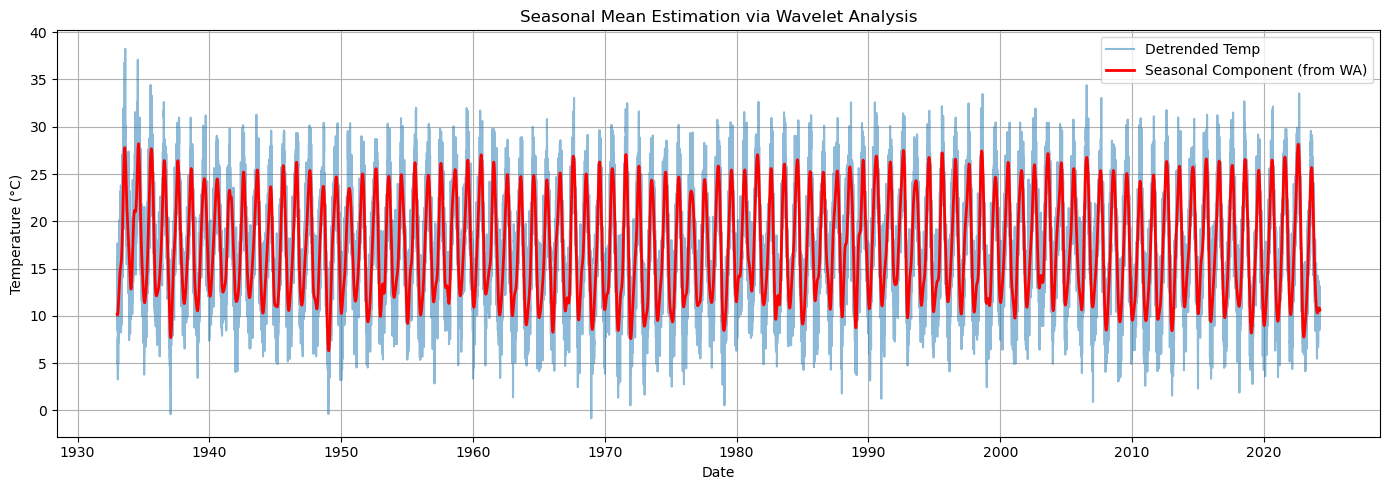

In [16]:
from WA_seasonal_mean import wavelet_reconstruct

keep = ['approx',  'detail_11', 'detail_10', 'detail_9', 'detail_8', 'detail_7']   
# Reconstruct seasonal component
seasonal_component = wavelet_reconstruct(coeff_dict, keep, wavelet_name='db11')
# Add this code to visualize each wavelet detail level separately
plt.figure(figsize=(15, 10))

# Add to DataFrame
df['seasonal'] = seasonal_component[:len(df)]  # match original length in case of rounding

# Plot to visualize seasonal component
plt.figure(figsize=(14, 5))

plt.plot(df['date'], df['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df['date'], df['seasonal'], label='Seasonal Component (from WA)', color='red', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

let's have a clearer idea by plotting just last 5 years

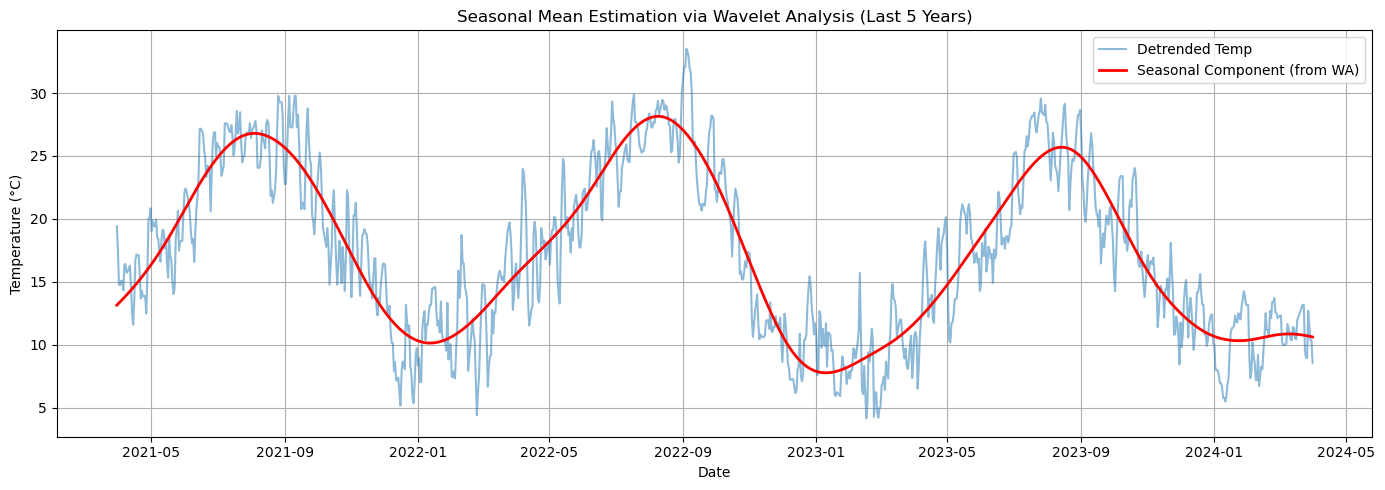

In [17]:
# Define the last 5-year window
end_date = df['date'].max()
start_date = end_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last5 = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Plot to visualize seasonal component for the last 5 years
plt.figure(figsize=(14, 5))

plt.plot(df_last5['date'], df_last5['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df_last5['date'], df_last5['seasonal'], label='Seasonal Component (from WA)', color='red', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis (Last 5 Years)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

let's compute the sinusoid

$$\mathcal{S}(t) = \sum_{i=1}^{n} a_i \cdot \sin\left( \frac{2\pi (t - \phi_i)}{p_i} \right)$$

Where:
*   $t$ is the day index
*   $a_i$: amplitude (to be fitted)
*   $\phi_i$: phase shift (to be fitted)
*   $p_i$: period in days (fixed from wavelet inspection)

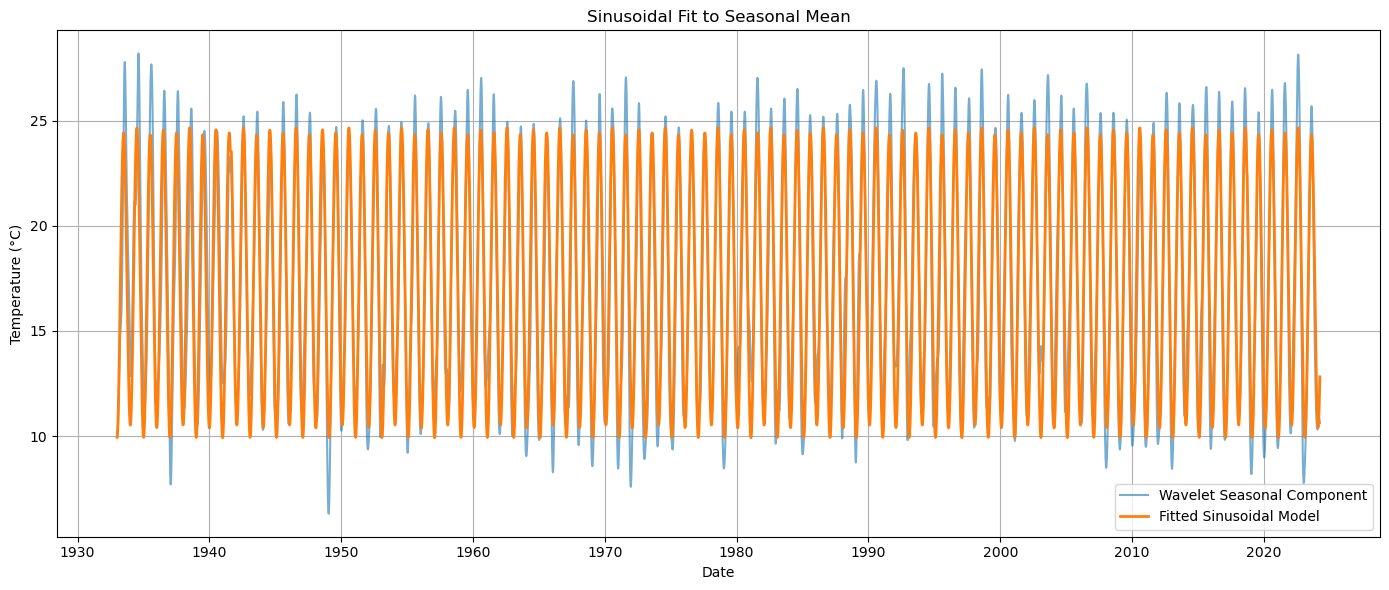

Cycle 1: Amplitude = 7.157, Phase Shift = 87.52, Period = 365 days
Cycle 2: Amplitude = 0.290, Phase Shift = 228.81, Period = 730 days
Cycle 3: Amplitude = 0.066, Phase Shift = 11.28, Period = 1460 days
Cycle 4: Amplitude = -0.170, Phase Shift = 454.22, Period = 2920 days
Fitted constant C: 17.3428


In [18]:

from scipy.optimize import curve_fit

# Step 1: Define the periods corresponding to detail_3, 4, 5
# You can fine-tune these later based on analysis or trial-error
periods = [365, 730, 1460, 2920]  # approx: 1 year, 2 years, 4 years

# Step 2: Define the sinusoidal model with these 3 fixed periods
def seasonal_model(t, C, a1, phi1, a2, phi2, a3, phi3, a4, phi4):
    p1, p2, p3 = 365, 730, 1460
    p4 = 2920  # ~8 years (modulation period)

    modulated = a4 * (1 + np.sin(2 * np.pi * (t - phi4) / p4)) * np.sin(2 * np.pi * t / 365)

    return C + (
        a1 * np.sin(2 * np.pi * (t - phi1) / p1) +
        a2 * np.sin(2 * np.pi * (t - phi2) / p2) +
        a3 * np.sin(2 * np.pi * (t - phi3) / p3) +
        modulated
    )

# Step 3: Prepare the data for fitting
t = df['t'].values
y = df['seasonal'].values
y_mean = np.mean(y)

# Initial guesses for [C0,a1, phi1, a2, phi2, a3, phi3]
initial_guess = [y_mean, 10, 100, 5, 200, 2, 300, 2, 400]
# Step 4: Fit the sinusoidal model
popt, pcov = curve_fit(seasonal_model, t, y, p0=initial_guess)

# Generate fitted seasonal values
df['fitted_seasonal'] = seasonal_model(t, *popt)

# Step 5: Plot the result
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df['date'], df['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Print the fitted parameters
for i in range(4):
    amp = popt[1 + 2*i]
    phase = popt[2 + 2*i]
    print(f"Cycle {i+1}: Amplitude = {amp:.3f}, Phase Shift = {phase:.2f}, Period = {periods[i]} days")

print(f"Fitted constant C: {popt[0]:.4f}")


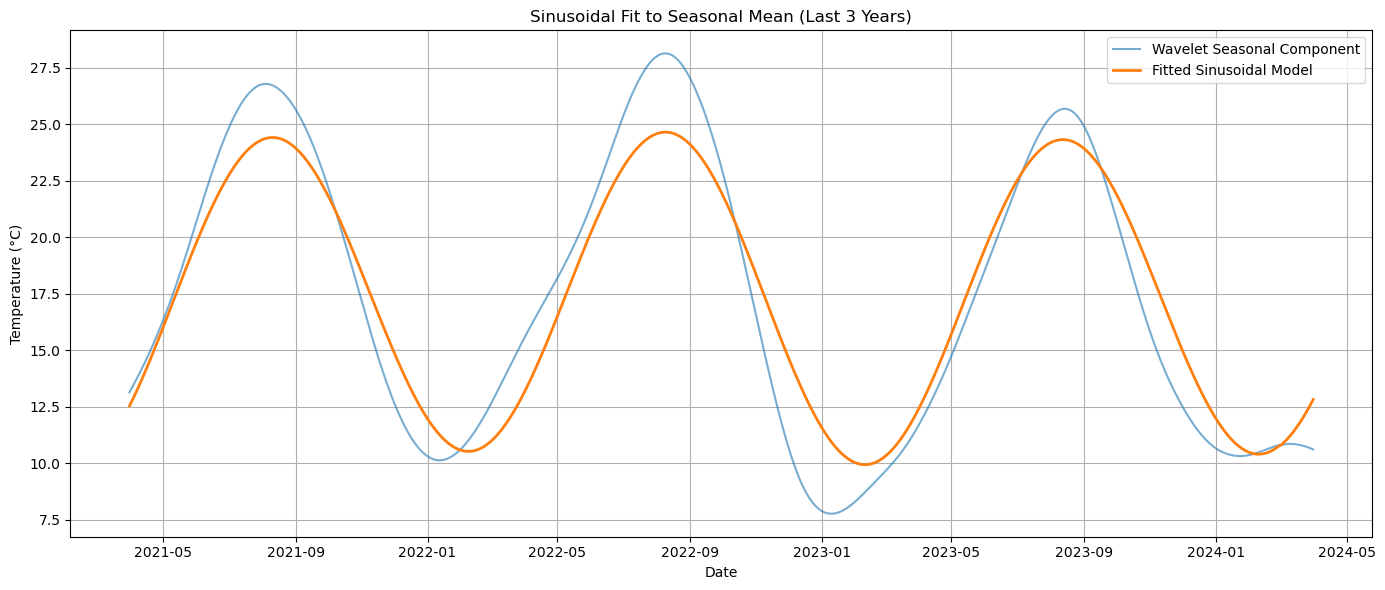

In [19]:
# Plot the last 3 years window
# Calculate the date 3 years before the last date
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df_last_3years['date'], df_last_3years['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df['residual'] = df['detrended_temp'] - df['fitted_seasonal']

np.save("S_seasonal.npy", df["residual"].values)

# Estimating the Mean Reversion Speed

In [21]:
# shortened data set for debugging
df_test = df.iloc[:5000]

df_test.head()

,date,mean,max,min,average_temperature,day_of_year,t,trend,detrended_temp,seasonal,fitted_seasonal,residual
0,1933-01-01,13.67,18.89,2.78,10.835,1,1,0.000022,10.834978,10.183185,9.937721,0.897256
1,1933-01-02,13.89,19.61,1.89,10.750,2,2,0.000045,10.749955,10.160545,9.947640,0.802315
2,1933-01-03,10.83,16.28,0.78,8.530,3,3,0.000067,8.529933,10.140653,9.959682,-1.429749
3,1933-01-04,14.94,21.28,1.28,11.280,4,4,0.000090,11.279910,10.123569,9.973844,1.306066
4,1933-01-05,18.11,23.50,6.89,15.195,5,5,0.000112,15.194888,10.109352,9.990122,5.204765


Using device: cpu
Starting variable selection using bootstrapped SBP...
Starting training with 50 epochs, batch size 32, learning rate 0.001
Model input shape: (26602, 10), output shape: (26602,)
Epoch 1/50 (2.0%) - Train Loss: 11.257227, Val Loss: 9.793941, Best Val: 9.793941, No Improve: 0
Time: 0.8s elapsed, ~38.4s remaining
Epoch 2/50 (4.0%) - Train Loss: 10.050512, Val Loss: 7.777184, Best Val: 7.777184, No Improve: 0
Time: 1.0s elapsed, ~24.8s remaining
Epoch 4/50 (8.0%) - Train Loss: 5.936250, Val Loss: 4.619743, Best Val: 4.619743, No Improve: 0
Time: 1.5s elapsed, ~17.5s remaining
Epoch 6/50 (12.0%) - Train Loss: 4.543467, Val Loss: 3.709342, Best Val: 3.709342, No Improve: 0
Time: 2.0s elapsed, ~14.9s remaining
Epoch 8/50 (16.0%) - Train Loss: 4.008279, Val Loss: 3.363748, Best Val: 3.363748, No Improve: 0
Time: 2.5s elapsed, ~13.4s remaining
Epoch 10/50 (20.0%) - Train Loss: 3.760663, Val Loss: 3.203839, Best Val: 3.203839, No Improve: 0
Time: 3.1s elapsed, ~12.2s remaining


/opt/anaconda3/envs/weatherder/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 5/100 (5.0%) - Train Loss: 11.591178, Val Loss: 10.714959, Best Val: 10.660173, No Improve: 4
Time: 0.8s elapsed, ~15.7s remaining
Epoch 10/100 (10.0%) - Train Loss: 11.595674, Val Loss: 10.704789, Best Val: 10.660173, No Improve: 9
Time: 1.6s elapsed, ~14.6s remaining
Epoch 15/100 (15.0%) - Train Loss: 11.594636, Val Loss: 10.694975, Best Val: 10.660173, No Improve: 14
Time: 2.4s elapsed, ~13.8s remaining
Epoch 20/100 (20.0%) - Train Loss: 11.646222, Val Loss: 10.707164, Best Val: 10.660173, No Improve: 19
Time: 3.2s elapsed, ~12.9s remaining
Epoch 25/100 (25.0%) - Train Loss: 11.599344, Val Loss: 10.702447, Best Val: 10.660173, No Improve: 24
Time: 4.0s elapsed, ~12.0s remaining
Epoch 30/100 (30.0%) - Train Loss: 11.589991, Val Loss: 10.693762, Best Val: 10.660173, No Improve: 29
Time: 4.8s elapsed, ~11.2s remaining
Epoch 35/100 (35.0%) - Train Loss: 11.621194, Val Loss: 10.696051, Best Val: 10.660173, No Improve: 34
Time: 5.6s elapsed, ~10.4s remaining
Epoch 40/100 (40.0%) - T

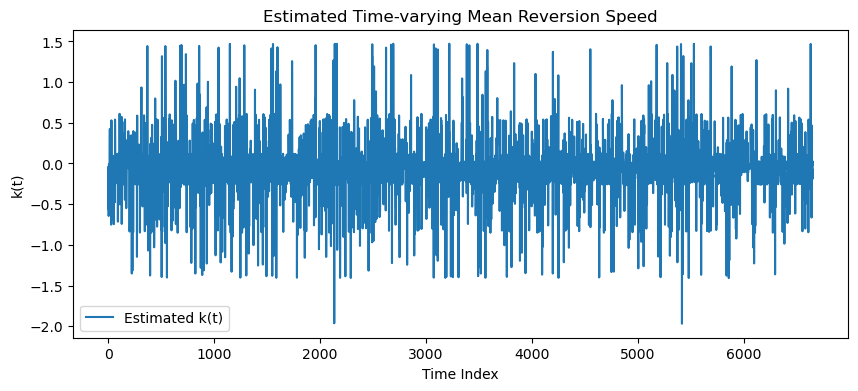

In [15]:
from WA_mean_reversion_speed import estimate_mean_reversion

# Call the main function to estimate mean reversion parameters.
# The function takes several parameters; here we are using example settings.
results = estimate_mean_reversion(
    deseasonalized_temp=df['residual'],  
    dates=df['date'], 
    max_lag=10,                    
    test_size=0.2,                 
    hidden_dim_range=[0, 5, 10, 20],
    wavelet='mexh',
    model_type='wavelet',
    do_variable_selection=True,    
    B=100,                         
    epochs=100,                    
    lr=0.001,
    batch_size=32
)

# Print out some key results
print("Optimal hidden units:", results['model'].wavelet_layer.scales.shape[0])
print("Selected active lags:", results['active_lags'])
print("Metrics:", results['metrics'])
print("First 5 estimated k-values:", results['k_values'][:5])

# plot the estimated mean reversion speed
plt.figure(figsize=(10, 4))
plt.plot(results['k_values'], label='Estimated k(t)')
plt.xlabel('Time Index')
plt.ylabel('k(t)')
plt.title('Estimated Time-varying Mean Reversion Speed')
plt.legend()
plt.show()

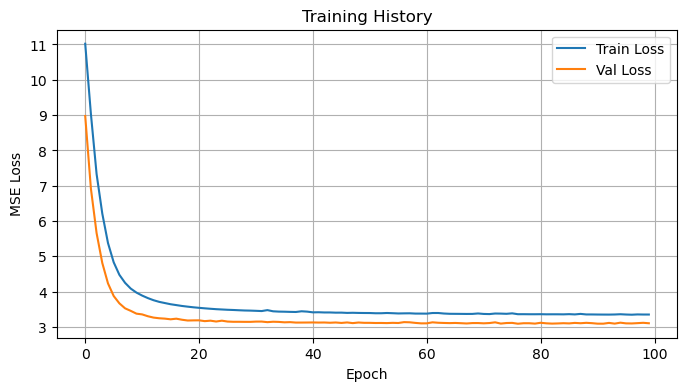

In [16]:
plt.figure(figsize=(8,4))
plt.plot(results['history']['train_loss'], label='Train Loss')
plt.plot(results['history']['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
results.keys()

dict_keys(['model', 'model_name', 'metrics', 'predictions', 'k_values', 'active_lags', 'history', 'residuals'])

In [18]:
import pickle

# To save:
with open('model_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [22]:
import pickle

# To load:
with open('model_results.pkl', 'rb') as f:
    results = pickle.load(f)

Using device: cpu


In [23]:
results['active_lags']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [24]:
from WA_mean_reversion_speed import get_full_k_series

# Get the full k(t) series
estimated_k_series, aligned_dates = get_full_k_series(
    data = df['residual'], 
    max_lag = 10,
    model_final = results['model'],
    dates = df['date'],
)



Model loaded correctly
Computed k values: [-0.05289191 -0.02967322 -0.05997145 ... -0.16877645  0.02624309
 -0.01125014]


In [25]:
print(estimated_k_series.shape)
print(df.shape)

print(aligned_dates[:5])

(33253,)
(33263, 12)
10   1933-01-11
11   1933-01-12
12   1933-01-13
13   1933-01-14
14   1933-01-15
Name: date, dtype: datetime64[ns]


In [26]:
# Match df for consitency with laggede values
df = df.iloc[10:]
df['k_series'] = estimated_k_series

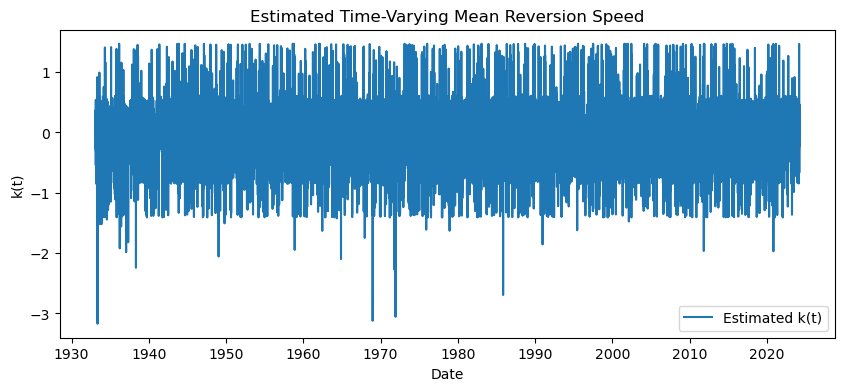

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(aligned_dates, df['k_series'], label='Estimated k(t)')
plt.xlabel('Date')
plt.ylabel('k(t)')
plt.title('Estimated Time-Varying Mean Reversion Speed')
plt.legend()
plt.show()

# Volatility modeling

We perform a Kolmogorov test to check if residuals are normal and a Ljung-Box lack of fit test to check if residuals are random or not

Jarque-Bera Test for Normality of Residuals

Jarque-Bera test for normality:
Statistic: 29.3128
P-value: 0.0000
Reject normality hypothesis: True


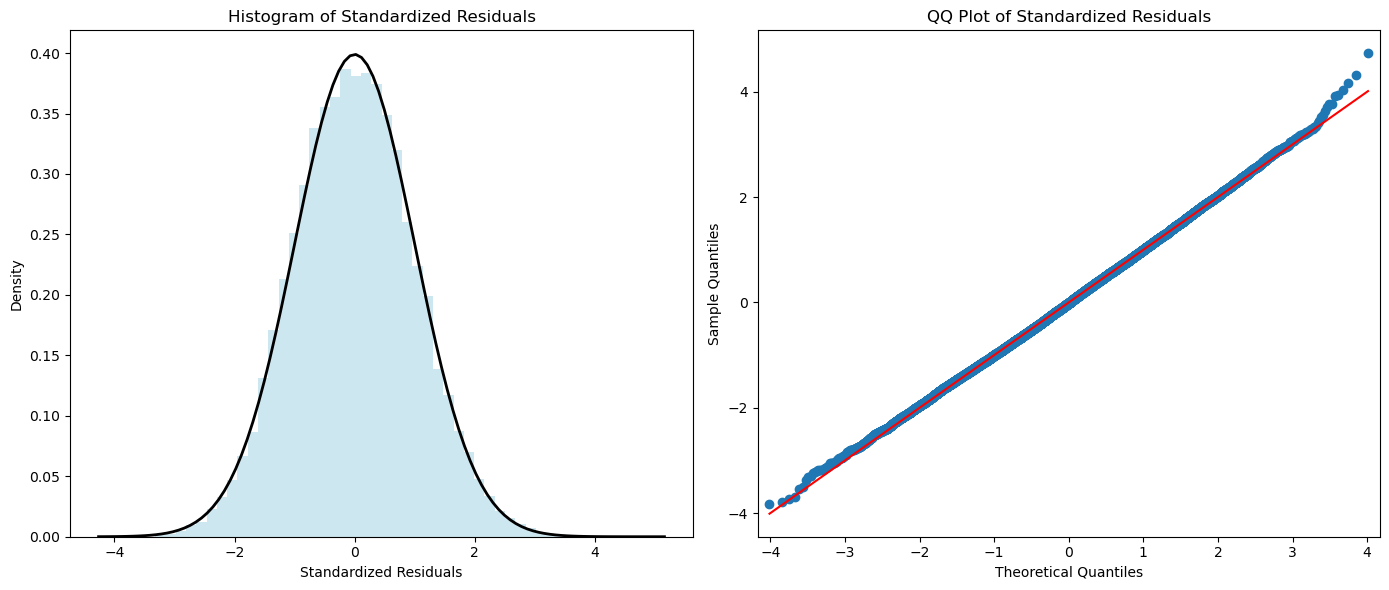


Ljung-Box Test for Autocorrelation of Residuals
         lb_stat  lb_pvalue
1   23381.860662        0.0
5   54809.553557        0.0
10  65804.590243        0.0
15  72841.093165        0.0
20  78121.981985        0.0
30  86109.330217        0.0

Interpretation:
Lag 1: Reject the null hypothesis - There is significant autocorrelation.
Lag 5: Reject the null hypothesis - There is significant autocorrelation.
Lag 10: Reject the null hypothesis - There is significant autocorrelation.
Lag 15: Reject the null hypothesis - There is significant autocorrelation.
Lag 20: Reject the null hypothesis - There is significant autocorrelation.
Lag 30: Reject the null hypothesis - There is significant autocorrelation.


<Figure size 1000x600 with 0 Axes>

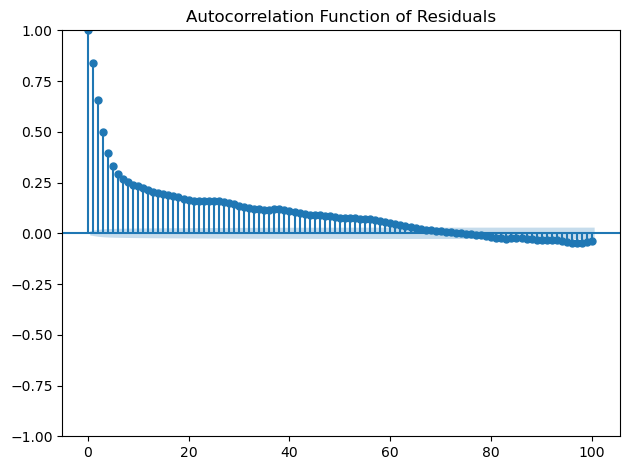

In [28]:
# Import necessary libraries
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# ---------- Jarque-Bera Test for Normality ----------
print("Jarque-Bera Test for Normality of Residuals")
residuals = df['residual'].dropna().values
# Standardize residuals (zero mean, unit variance)
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
# Perform Jarque-Bera test
jb_stat, jb_pval = stats.jarque_bera(standardized_residuals)
print(f"\nJarque-Bera test for normality:")
print(f"Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pval:.4f}")
print(f"Reject normality hypothesis: {jb_pval < 0.05}")



# Visual assessment of normality
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(standardized_residuals, bins=50, density=True, alpha=0.6, color='lightblue')
# Add a normal density curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
qqplot(standardized_residuals, line='s', ax=plt.gca())
plt.title('QQ Plot of Standardized Residuals')
plt.tight_layout()
plt.show()

# ---------- Ljung-Box Test for Autocorrelation ----------
print("\nLjung-Box Test for Autocorrelation of Residuals")
# Test for different lags
lags = [1, 5, 10, 15, 20, 30]

# Handle different versions of statsmodels
try:
    # Try with return_df=True (newer versions of statsmodels)
    lb_results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    
    # Check if 'lb_pvalue' and 'lb_stat' exist, if not, rename 'model_qstat' and 'model_pvalue'
    if 'lb_pvalue' not in lb_results.columns and 'lb_stat' not in lb_results.columns:
        lb_results = lb_results.rename(columns={'model_qstat': 'lb_stat', 'model_pvalue': 'lb_pvalue'})
    
    # Already a DataFrame, just print it
    print(lb_results)
    print("\nInterpretation:")
    for lag in lags:
        # Find the row for this lag
        # Use .loc to find the row where 'lag' column equals the current lag
        # Check if 'lag' column exists, if not, create it
        if 'lag' not in lb_results.columns:
            lb_results['lag'] = lags[:len(lb_results)]  # Ensure 'lags' is not longer than lb_results
        row = lb_results.loc[lb_results['lag'] == lag]
       
        if not row.empty:
            p_value = row['lb_pvalue'].values[0]
            if p_value <= 0.05:
                print(f"Lag {lag}: Reject the null hypothesis - There is significant autocorrelation.")
            else:
                print(f"Lag {lag}: Failed to reject the null hypothesis - No significant autocorrelation.")
        else:
            print(f"Lag {lag}: Not found in Ljung-Box test results.")
        
except (TypeError, ValueError):
    # Fall back to older statsmodels version
    lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=lags)
    
    # Create a DataFrame for better visualization
    lb_df = pd.DataFrame({
        'Lag': lags,
        'Test Statistic': lb_stat,
        'p-value': lb_pvalue
    })
    
    print(lb_df)
    print("\nInterpretation:")
    for idx, lag in enumerate(lags):
        if lb_pvalue[idx] <= 0.05:
            print(f"Lag {lag}: Reject the null hypothesis - There is significant autocorrelation.")
        else:
            print(f"Lag {lag}: Failed to reject the null hypothesis - No significant autocorrelation.")

# Visual assessment of autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=100, alpha=0.05, title='Autocorrelation Function of Residuals')
plt.tight_layout()
plt.show()

To model the variance, we work with squared residuals:

$$
Y(t) = \left( T(t) - S(t) \right)^2 = X(t)^2 \approx \sigma^2(t)

In [29]:
df['squared_residual'] = df['residual']**2

In [30]:
print(len(df['squared_residual']))
df.head()

33253


,date,mean,max,min,average_temperature,day_of_year,t,trend,detrended_temp,seasonal,fitted_seasonal,residual,k_series,squared_residual
10,1933-01-11,13.44,16.28,8.00,12.140,11,11,0.000247,12.139753,10.087325,10.131899,2.007854,-0.052892,4.031479
11,1933-01-12,17.22,22.39,4.61,13.500,12,12,0.000270,13.499730,10.094654,10.162813,3.336918,-0.029673,11.135020
12,1933-01-13,19.33,23.50,11.89,17.695,13,13,0.000292,17.694708,10.105215,10.195786,7.498922,-0.059971,56.233834
13,1933-01-14,18.89,23.00,11.89,17.445,14,14,0.000314,17.444686,10.119019,10.230808,7.213878,-0.190776,52.040033
14,1933-01-15,10.39,12.39,8.00,10.195,15,15,0.000337,10.194663,10.136072,10.267868,-0.073205,-0.131061,0.005359


let's plot them:

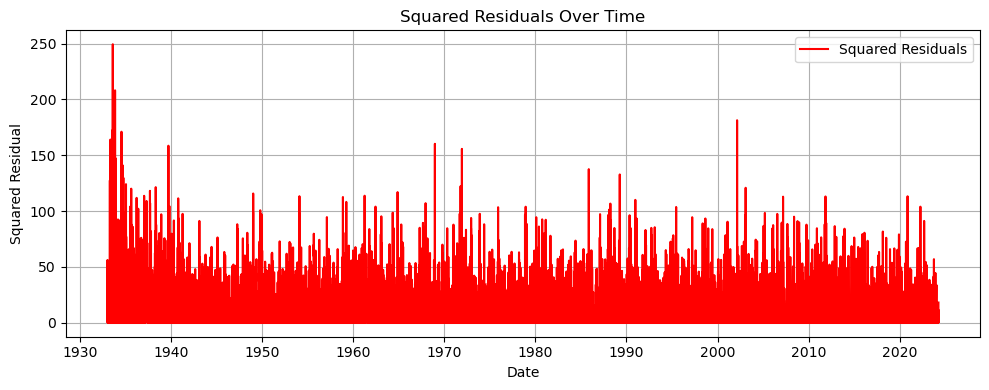

In [31]:
# Plot the squared residuals
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['squared_residual'], color='red', label='Squared Residuals')
plt.title("Squared Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Squared Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

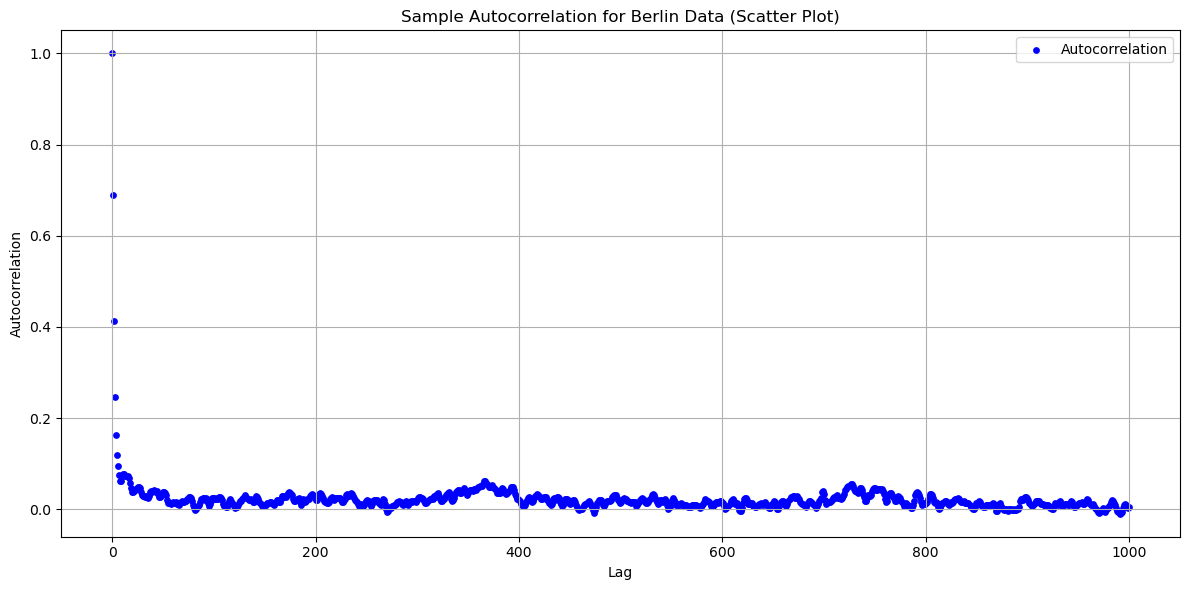

In [32]:
from statsmodels.tsa.stattools import acf

data = df['squared_residual'].values

# Compute the autocorrelation for lags 
nlags = 1000
autocorr_vals = acf(data, nlags=nlags)

# Create an array of lags from 0 to 1000
lags = np.arange(nlags+1)

# Plot using a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(lags, autocorr_vals, color='blue', s=15, label='Autocorrelation')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Sample Autocorrelation for Berlin Data (Scatter Plot)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The volatility is also seasonal (e.g. winter more volatile than summer). So we do a wavelet decomposition of the squared residuals and reconstruct the seasonal part using appropriate detail levels. Essentialy we repeat what we did in the seasonal mean part

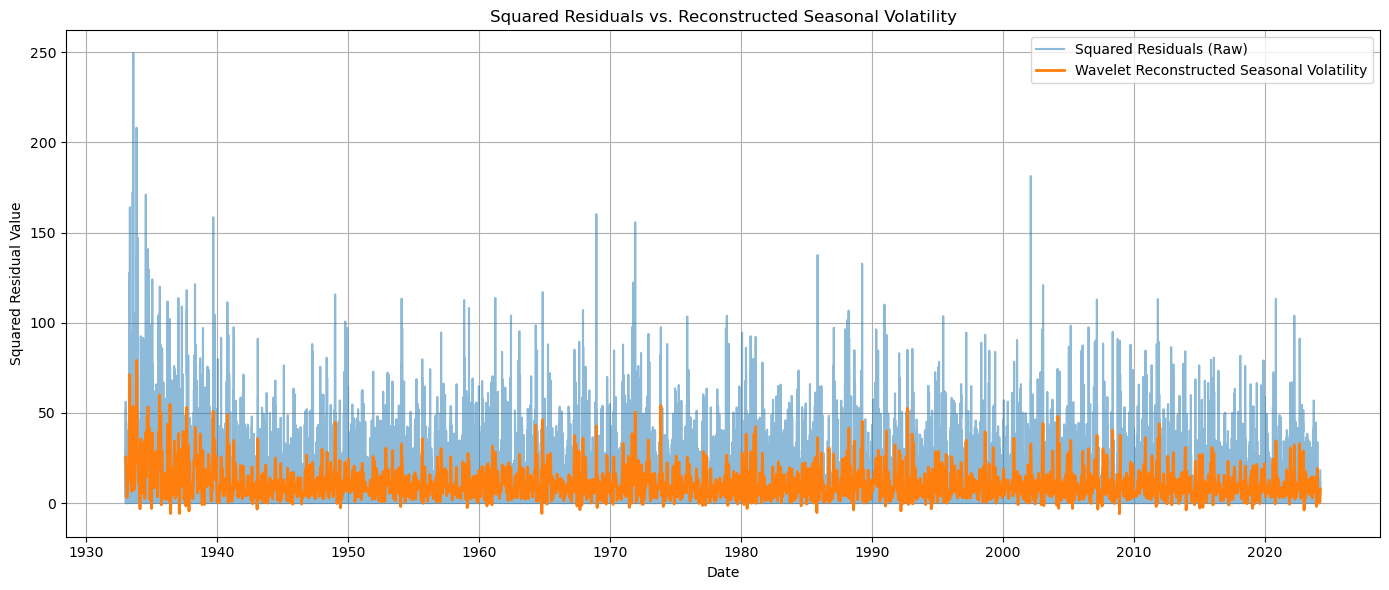

In [33]:
from WA_seasonal_mean import wavelet_decompose, wavelet_reconstruct

# ---------- Step 1: Wavelet Decomposition and Reconstruction of Squared Residuals ----------

# Decompose the squared residuals using wavelets (example with Daubechies 11)
vol_coeffs = wavelet_decompose(df['squared_residual'], wavelet_name='db11')

# Choose selected levels to capture the seasonal volatility structure.
# Here we choose the approximation plus details 3, 4, and 5.
keep_vol = ['approx', 'detail_11', 'detail_10', 'detail_9', 'detail_8', 'detail_7', 'detail_6', 'detail_5']

# Reconstruct the seasonal volatility component from these levels.
volatility_seasonal = wavelet_reconstruct(vol_coeffs, keep_vol, wavelet_name='db11')
df['seasonal_volatility'] = volatility_seasonal[:len(df)]  # Ensure matching length

# ---------- Step 2: Plot the Squared Residuals and the Reconstructed Seasonal Volatility ----------

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['squared_residual'], label='Squared Residuals (Raw)', alpha=0.5)
plt.plot(df['date'], df['seasonal_volatility'], label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility")
plt.xlabel("Date")
plt.ylabel("Squared Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


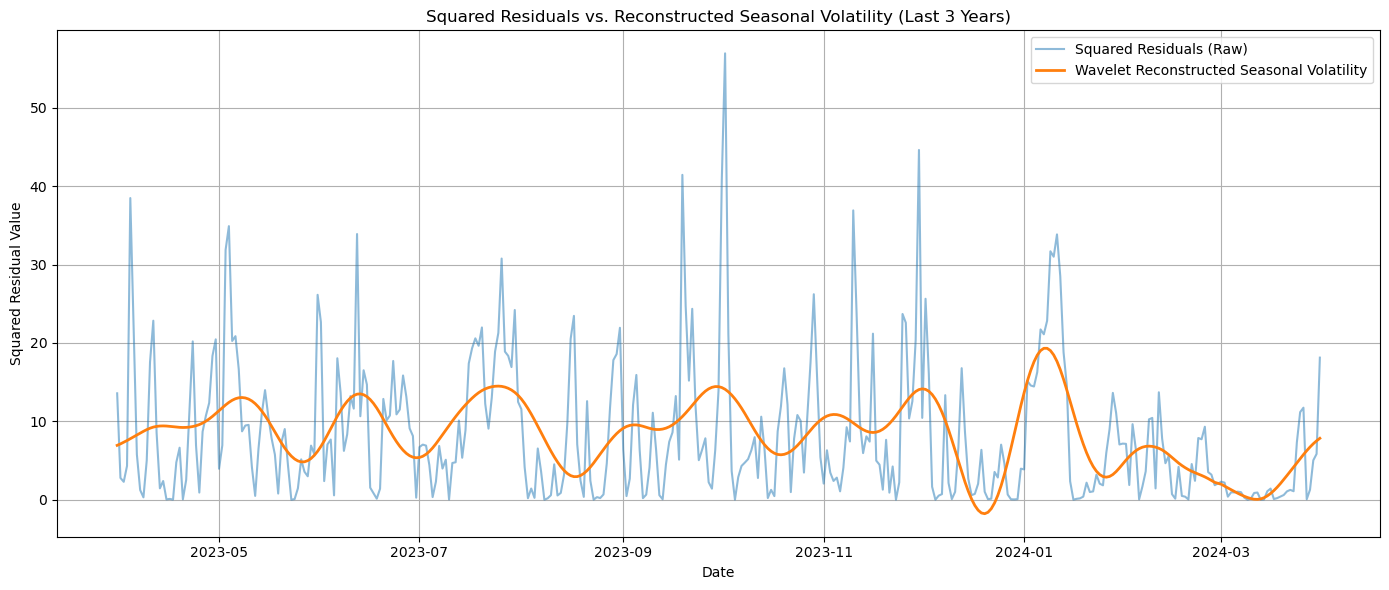

In [34]:
# Plot for the last 3 years
# Calculate the date range
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=1)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['squared_residual'], 
         label='Squared Residuals (Raw)', alpha=0.5)
plt.plot(df_last_3years['date'], df_last_3years['seasonal_volatility'], 
         label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Squared Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

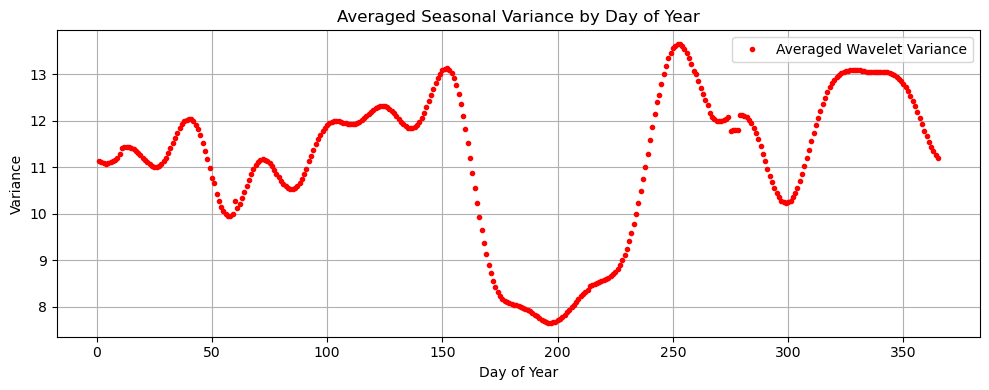

In [35]:
df['seasonal_volatility'] = volatility_seasonal[:len(df)]  # Ensure matching length

# =============================================================================
# STEP 4: Prepare Averaged Data by Day of Year for Fourier Fitting
#
# Since the paper assumes var(t+365)=var(t), we average the wavelet variance 
# over each day-of-year (1 to 365).
# =============================================================================
avg_var = df.groupby('day_of_year')['seasonal_volatility'].mean()
days = np.arange(1, 366)
avg_var_values = avg_var.reindex(days).values

plt.figure(figsize=(10, 4))
plt.plot(days, avg_var_values, 'r.', label='Averaged Wavelet Variance')
plt.title("Averaged Seasonal Variance by Day of Year")
plt.xlabel("Day of Year")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



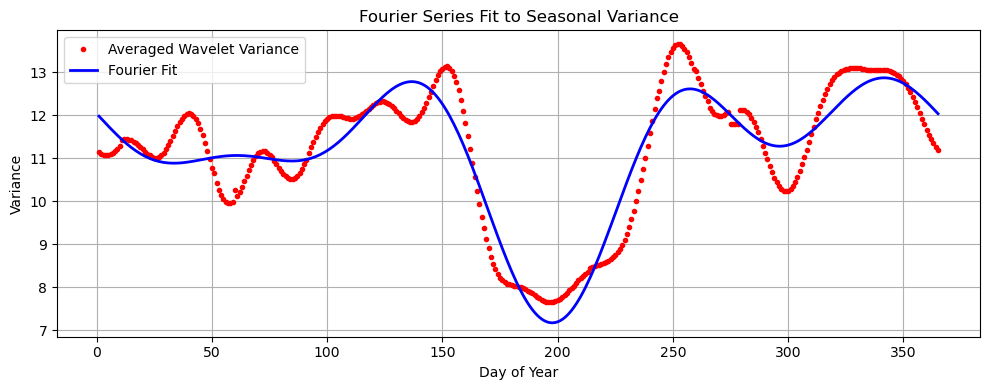

In [36]:

# =============================================================================
# STEP 5: Define the Truncated Fourier Series Model for Variance
#
# We use the following model:
#
#   var(t) = c0 + sum_{k=1}^K [ a_k*cos(2*pi*k*t/365) + b_k*sin(2*pi*k*t/365) ]
#
# For demonstration, we set K = 4 harmonics.
# =============================================================================
def fourier_variance_model(t, c0, a1, b1, a2, b2, a3, b3, a4, b4):
    return (c0 +
            a1 * np.cos(2 * np.pi * 1 * t / 365) + b1 * np.sin(2 * np.pi * 1 * t / 365) +
            a2 * np.cos(2 * np.pi * 2 * t / 365) + b2 * np.sin(2 * np.pi * 2 * t / 365) +
            a3 * np.cos(2 * np.pi * 3 * t / 365) + b3 * np.sin(2 * np.pi * 3 * t / 365) +
            a4 * np.cos(2 * np.pi * 4 * t / 365) + b4 * np.sin(2 * np.pi * 4 * t / 365))

# =============================================================================
# STEP 6: Fit the Fourier Model Using curve_fit
#
# Although this model is linear in parameters, we will use curve_fit for consistency.
# =============================================================================
# Initial guesses (adjust these as needed based on the scale of your variance)
initial_guess = [5, 1, 1, 0.5, 0.5, 0.2, 0.2, 0.1, 0.1]

popt, pcov = curve_fit(fourier_variance_model, days, avg_var_values, p0=initial_guess)

# Generate the fitted variance values from the Fourier model
fitted_var_fourier = fourier_variance_model(days, *popt)

# =============================================================================
# STEP 7: Plot the Fourier Fit vs Averaged Wavelet Variance
# =============================================================================
plt.figure(figsize=(10, 4))
plt.plot(days, avg_var_values, 'r.', label='Averaged Wavelet Variance')
plt.plot(days, fitted_var_fourier, 'b-', linewidth=2, label='Fourier Fit')
plt.title("Fourier Series Fit to Seasonal Variance")
plt.xlabel("Day of Year")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [37]:
print(fitted_var_fourier.shape)


(365,)


In [38]:
# Get day of year for each date in your dataframe
# If date is a column:
day_of_year = df['date'].dt.dayofyear

# If date is the index:
# day_of_year = df.index.dayofyear

# Create a mapping from day of year (1-366) to the fitted variance values
# We need a 366-day mapping to handle leap years (day 366 will just use day 365's value)
day_to_variance = {}
for i, day in enumerate(days):
    day_int = int(day)
    day_to_variance[day_int] = np.sqrt(fitted_var_fourier[i])

# If there's no day 366 in the model but we have leap years in the data
if 366 not in day_to_variance and max(days) < 366:
    day_to_variance[366] = day_to_variance[365]  # Use last day for leap years

# Map the sigma values to each day in the dataframe
df['sigma_t'] = day_of_year.map(lambda x: day_to_variance.get(x, np.nan))

# Check if all days got mapped properly
if df['sigma_t'].isna().any():
    print(f"Warning: {df['sigma_t'].isna().sum()} dates could not be mapped to the seasonal variance model")


np.save("sigma_timevarying.npy", df["sigma_t"].values)

In [39]:
# =============================================================================
# STEP 8: Print Fitted Parameters (Optional)
# =============================================================================
param_names = ['c0', 'a1', 'b1', 'a2', 'b2', 'a3', 'b3', 'a4', 'b4']
print("Fitted Fourier Model Parameters for Seasonal Variance:")
for name, value in zip(param_names, popt):
    print(f"{name} = {value:.4f}")

Fitted Fourier Model Parameters for Seasonal Variance:
c0 = 11.1488
a1 = 1.0094
b1 = -0.0154
a2 = -0.7326
b2 = -0.9355
a3 = 0.9678
b3 = 0.5327
a4 = -0.3588
b4 = -0.7586


# Residual analysis

In [40]:
print(df['k_series'].shape)
print(df['residual'].shape)

df.head()

(33253,)
(33253,)


,date,mean,max,min,average_temperature,day_of_year,t,trend,detrended_temp,seasonal,fitted_seasonal,residual,k_series,squared_residual,seasonal_volatility,sigma_t
10,1933-01-11,13.44,16.28,8.00,12.140,11,11,0.000247,12.139753,10.087325,10.131899,2.007854,-0.052892,4.031479,25.614293,3.381010
11,1933-01-12,17.22,22.39,4.61,13.500,12,12,0.000270,13.499730,10.094654,10.162813,3.336918,-0.029673,11.135020,25.696612,3.373913
12,1933-01-13,19.33,23.50,11.89,17.695,13,13,0.000292,17.694708,10.105215,10.195786,7.498922,-0.059971,56.233834,25.702684,3.367071
13,1933-01-14,18.89,23.00,11.89,17.445,14,14,0.000314,17.444686,10.119019,10.230808,7.213878,-0.190776,52.040033,25.629546,3.360503
14,1933-01-15,10.39,12.39,8.00,10.195,15,15,0.000337,10.194663,10.136072,10.267868,-0.073205,-0.131061,0.005359,25.475031,3.354227


In [41]:
epsilons = []

for t in range(1, len(df)):
    prev = df.iloc[t-1]
    curr = df.iloc[t]
    
    not_e_t = curr['residual'] - prev['residual'] - prev['k_series'] * curr['residual']
    e_t = not_e_t / np.sqrt(curr['sigma_t'])
    
    epsilons.append(e_t)

epsilons = np.array(epsilons)

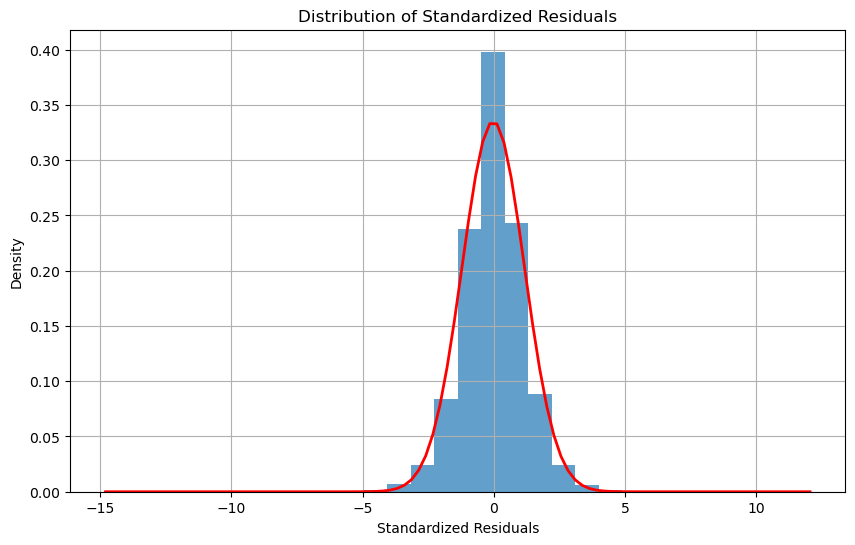

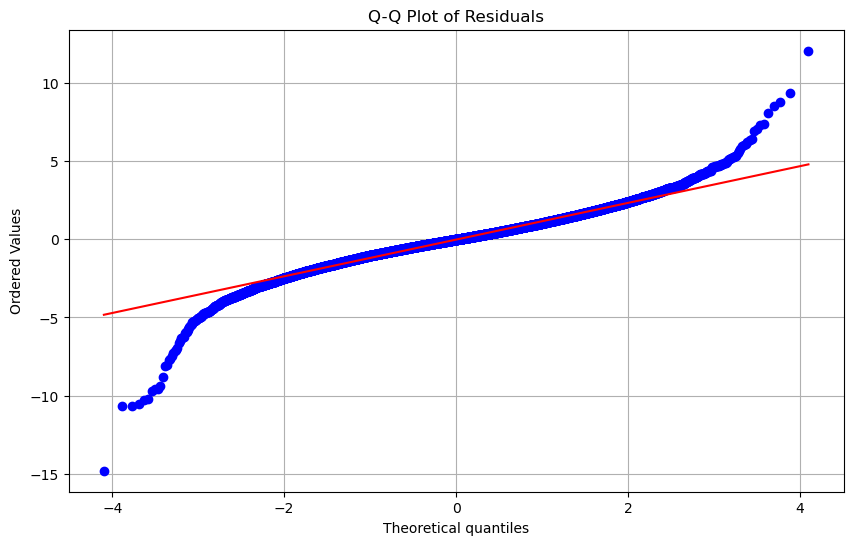

<Figure size 1000x600 with 0 Axes>

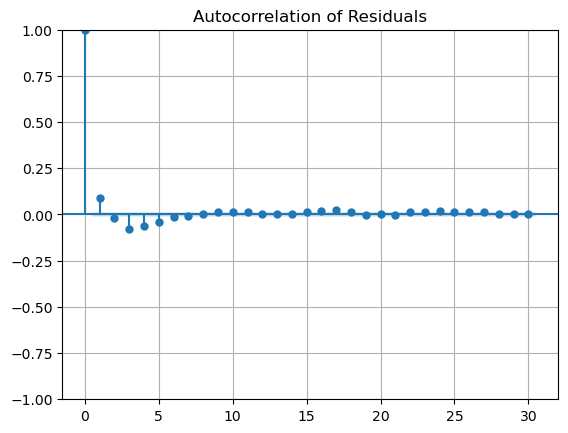


Residuals Summary Statistics:
Mean: -0.0271
Std Dev: 1.1906
Skewness: -0.2378
Kurtosis: 4.5926

Jarque-Bera test for normality:
Statistic: 29536.1812
P-value: 0.0000
Reject normality hypothesis: True

Ljung-Box test for autocorrelation (lag=10):
Results:        lb_stat      lb_pvalue
10  687.755877  2.667972e-141


In [42]:
# Step 8: Check residuals for normality and independence
plt.figure(figsize=(10, 6))
plt.hist(epsilons, bins=30, alpha=0.7, density=True)
plt.title('Distribution of Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')

# Add normal distribution curve
x = np.linspace(min(epsilons), max(epsilons), 100)
plt.plot(x, stats.norm.pdf(x, np.mean(epsilons), np.std(epsilons)), 'r-', linewidth=2)
plt.grid(True)
plt.show()

# QQ plot for residuals
plt.figure(figsize=(10, 6))
stats.probplot(epsilons, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

# ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(epsilons, lags=30)
plt.title('Autocorrelation of Residuals')
plt.grid(True)
plt.show()

# Summary statistics
print("\nResiduals Summary Statistics:")
print(f"Mean: {np.mean(epsilons):.4f}")
print(f"Std Dev: {np.std(epsilons):.4f}")
print(f"Skewness: {stats.skew(epsilons):.4f}")
print(f"Kurtosis: {stats.kurtosis(epsilons):.4f}")

# Jarque-Bera test for normality
jb_stat, jb_pval = stats.jarque_bera(epsilons)
print(f"\nJarque-Bera test for normality:")
print(f"Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pval:.4f}")
print(f"Reject normality hypothesis: {jb_pval < 0.05}")

# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_results = acorr_ljungbox(epsilons, lags=[10], return_df=False)

# Check the type of results and handle accordingly
if isinstance(lb_results, tuple) and len(lb_results) == 2:
    lb_stat, lb_pval = lb_results
    print(f"\nLjung-Box test for autocorrelation (lag=10):")
    print(f"Statistic: {float(lb_stat[0]):.4f}")
    print(f"P-value: {float(lb_pval[0]):.4f}")
    print(f"Evidence of autocorrelation: {float(lb_pval[0]) < 0.05}")
else:
    print("\nLjung-Box test for autocorrelation (lag=10):")
    print(f"Results: {lb_results}")